In [1]:
%load_ext autoreload
%autoreload 2

# TODO
1. Add datatypes
2. Create PIP package
3. Additional document in __call__()
4. READme

In [31]:
from PIL import Image, ImageDraw, ImageFont
from typing import Dict, Tuple

def draw_box(pil_img: Image, layout_info: Dict[str, Tuple[float, float, float, float]]) -> Image:
    # initialize width, height from pil_img
    width, height = pil_img.size
    draw = ImageDraw.Draw(pil_img)

    for phrase, bbox in layout_info.items():
        x_0, y_0, x_1, y_1 = bbox
        draw.rectangle([int(x_0 * width), int(y_0 * height), int(x_1 * width), int(y_1 * height)], outline='red', width=4)
        draw.text((int(x_0 * width) + 5, int(y_0 * height) + 5), phrase, fill=(255, 0, 0))
    return pil_img


In [9]:
from layoutguidance.layout_guidance_pipeline import LayoutGuidanceStableDiffusionPipeline
from diffusers import HeunDiscreteScheduler
import torch
seed = 33

pipe = LayoutGuidanceStableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipe.to("mps")
pipe.scheduler = HeunDiscreteScheduler.from_config(pipe.scheduler.config)
generator = torch.Generator(device="mps").manual_seed(seed)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


[[3]]


  0%|          | 0/1 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


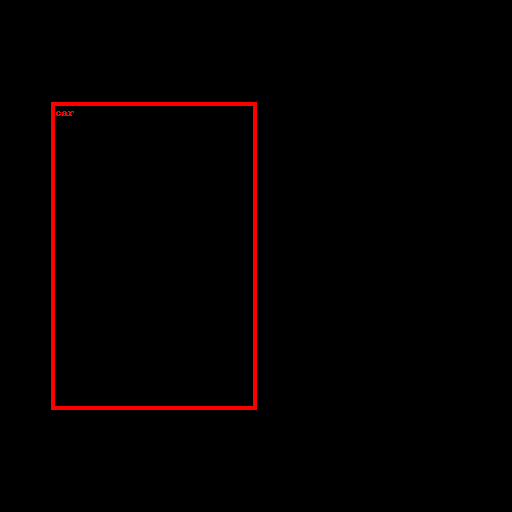

In [36]:
prompt = "A red car"
layout_info = {"car": [0.1, 0.2, 0.5, 0.8]}
image = pipe(prompt, num_inference_steps=1, layout_info=layout_info).images[0]
image = draw_box(image, layout_info)
display(image)